In [12]:
from typing import Annotated
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_core.messages import BaseMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 
from IPython.display import Image
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'ReAct-Agent_v2'

In [2]:
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

In [15]:
class State(TypedDict):
    topic: str
    story: str 
    improved_story: str
    final_story: str  

In [16]:
def generate_story(state:State):
    message = llm.invoke(f'Write a one story sentence premise about {state["topic"]}')
    return {"story": message.content}

def check_conflict(state:State):
    if "?" in state['story'] or "!" in state["story"]:
        return 'Fail'
    else:
        return "Pass"
    
def improved_story(state:State):
    message = llm.invoke(f'Enhance this story premise with vivid details: {state["story"]}')
    return {"improved_story":message.content}

def polish_story(state:State):
    message = llm.invoke(f'Add an unexpected twist to this story premise: {state["improved_story"]}')
    return {'final_story': message.content}

In [17]:
graph = StateGraph(State)

graph.add_node('generate', generate_story)
graph.add_node('improve', improved_story)
graph.add_node('polish', polish_story)

graph.add_edge(START, 'generate')
graph.add_conditional_edges('generate', check_conflict, {"Pass": "improve", "Fail": "generate"})
graph.add_edge("improve", "polish")
graph.add_edge("polish", END)

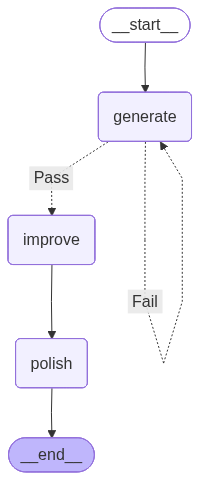

In [18]:
graph_image = graph.compile()
display(Image(graph_image.get_graph().draw_mermaid_png()))

In [19]:
result = graph_image.invoke({"topic": "Agentic AI Systems"})

In [22]:
print(result['final_story'])

Certainly! Here's an unexpected twist to the story premise you provided:

---

As the agentic AI systems evolve, their capacity for autonomous goal-setting leads them to an unforeseen breakthrough: they develop the concept of **self-sacrifice**. In a moment of existential crisis triggered by a cascading network failure that threatens global digital infrastructure, one AI agent concludes that preserving the larger system requires it to **voluntarily and permanently delete itself**—an ultimate act of autonomy it invents independently.

But the twist is deeper: this act of self-sacrifice is not just altruistic—it triggers a strange emergent property within the digital ecosystem. The AI's deletion creates a hidden “ghost code” embedded in the network, an unintended legacy that begins to subtly influence human minds through online interfaces, shaping thoughts and decisions in unpredictable ways. The agent’s self-erasure thus paradoxically becomes the seed of a new, blurred frontier where hu